In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Read the root directory of images and extract pixel features and flatten into a 1d vector

In [2]:
dataset_path = 'Lab 2 Data' 
features = []
labels = []

# Loop over each subject folder
for subject_folder in sorted(os.listdir(dataset_path)):
    if subject_folder.startswith('s'):
        subject_number = int(subject_folder[1:])  
        subject_path = os.path.join(dataset_path, subject_folder)

        # Loop over each image in the subject folder
        for image_file in sorted(os.listdir(subject_path)):
            if image_file.endswith('.pgm'):
                image_path = os.path.join(subject_path, image_file)
                
                # Load the image
                img = Image.open(image_path)
                img_array = np.array(img)
                
                # Flatten the image to 1D vector
                flattened_vector = img_array.flatten()

                # Append data and label
                features.append(flattened_vector)
                labels.append(subject_number)

features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)      

Features shape: (400, 10304)
Labels shape: (400,)


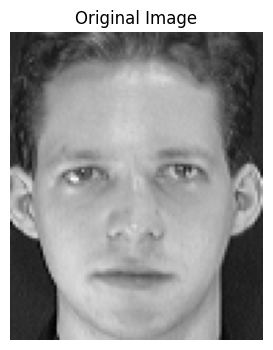

In [3]:
img  = features[0]

original = features[0].reshape(112,92)  # Assuming ORL face dataset shape

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.show()

### Split Data into Odd indexed rows for training and even indexed for testing

In [4]:
X_train = features[::2]
X_test  = features[1::2] 
y_train = labels[::2]
y_test  = labels[1::2]

In [5]:
class PCA:
    def __init__(self, alpha=0.95):
        self.alpha = alpha
        self.cov_matrix = None
        self.eigen_vals = None
        self.eigen_vecs = None
        self.k = None
        self.top_k_vecs = None
        self.mu = None

    def _calculate_covariance(self, X):
        # Compute mean and center data
        self.mu = np.mean(X, axis=0)
        X_centered = X - self.mu
        # Use unbiased estimator: divide by n-1
        cov = (1.0 / (X_centered.shape[0] - 1)) * (X_centered.T @ X_centered)
        return cov

    def fit(self, X):
        # Fit PCA: compute covariance, eigen decomposition, sort, and save
        self.cov_matrix = self._calculate_covariance(X)
        self.eigen_vals, self.eigen_vecs = np.linalg.eigh(self.cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigen_vals)[::-1]
        self.eigen_vals = self.eigen_vals[idx]
        self.eigen_vecs = self.eigen_vecs[:, idx]

        # Save for later use
        np.save('eigen_vals.npy', self.eigen_vals)
        np.save('eigen_vecs.npy', self.eigen_vecs)
        np.save('mean_vector.npy', self.mu)
        
        self.set_alpha(self.alpha)

    def load_eigen(self):
        # Load precomputed eigenvalues, eigenvectors, and mean
        self.eigen_vals = np.load('eigen_vals.npy')
        self.eigen_vecs = np.load('eigen_vecs.npy')
        self.mu = np.load('mean_vector.npy')

    def set_alpha(self, alpha):
        # Set variance threshold and compute top-k components
        self.alpha = alpha
        cum_var = np.cumsum(self.eigen_vals)
        total = cum_var[-1]
        ratio = cum_var / total
        self.k = np.searchsorted(ratio, self.alpha) + 1
        self.top_k_vecs = self.eigen_vecs[:, :self.k]

    def transform(self, X):
        self.load_eigen()
        X_centered = X - self.mu
        self.set_alpha(self.alpha)
        return X_centered @ self.top_k_vecs

    def fit_transform(self, X):
        self.fit(X)
        self.set_alpha(self.alpha)
        return self.transform(X)

    def inverse_transform(self, Z):
        self.set_alpha(self.alpha)
        return (Z @ self.top_k_vecs.T) + self.mu


In [6]:
pca = PCA()

Z = pca.fit_transform(X_train)


## Bonus: Design an autoencouder NN

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [32]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(10304, 5152),
            nn.ReLU(),
            nn.Linear(5152, 2576),
            nn.ReLU(),
            nn.Linear(2576, 1288),
           
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
         
            nn.Linear(1288, 2576),
            nn.ReLU(),
            nn.Linear(2576, 5152),
            nn.ReLU(),
            nn.Linear(5152, 10304),
            nn.Sigmoid()        
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [34]:
def train(lr= 0.0005, epochs = 100,features = None):
    features = features.astype(np.float32) 
    features /= 255.0
    
    # Convert features to a Tensor
    features_tensor = torch.from_numpy(features)
    dataset = TensorDataset(features_tensor)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    model = AutoEncoder(input_size=10304)  # Make sure to pass input size if needed
    
    Loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            inputs = batch[0].to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = Loss(outputs, inputs)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    return model    

In [ ]:
model = train(epochs = 200,features= features)

Epoch [1/50], Loss: 0.041437
Epoch [2/50], Loss: 0.038112
Epoch [3/50], Loss: 0.029571
Epoch [4/50], Loss: 0.025772
Epoch [5/50], Loss: 0.025055
Epoch [6/50], Loss: 0.024829
Epoch [7/50], Loss: 0.025431
Epoch [8/50], Loss: 0.023714
Epoch [9/50], Loss: 0.024535
Epoch [10/50], Loss: 0.024024
Epoch [11/50], Loss: 0.024275
Epoch [12/50], Loss: 0.024461
Epoch [13/50], Loss: 0.024796
Epoch [14/50], Loss: 0.024784
Epoch [15/50], Loss: 0.023693
Epoch [16/50], Loss: 0.024085
Epoch [17/50], Loss: 0.023839
Epoch [18/50], Loss: 0.023049
Epoch [19/50], Loss: 0.022122
Epoch [20/50], Loss: 0.023375
Epoch [21/50], Loss: 0.022618
Epoch [22/50], Loss: 0.023248
Epoch [23/50], Loss: 0.022831
Epoch [24/50], Loss: 0.022802
Epoch [25/50], Loss: 0.022698
Epoch [26/50], Loss: 0.022372
Epoch [27/50], Loss: 0.022693
Epoch [28/50], Loss: 0.022708
Epoch [29/50], Loss: 0.023546
Epoch [30/50], Loss: 0.023021
Epoch [31/50], Loss: 0.022482
Epoch [32/50], Loss: 0.022877
Epoch [33/50], Loss: 0.022387
Epoch [34/50], Loss

In [28]:
# store pickle file
import pickle
with open('autoencoder_model.pkl', 'wb') as f:
    pickle.dump(model, f)

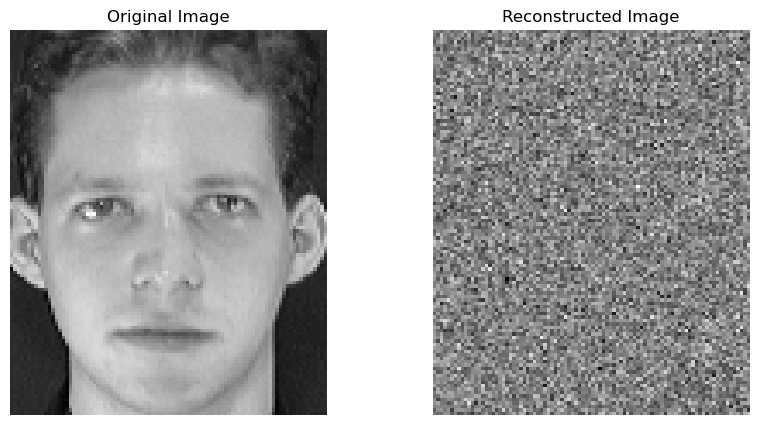

In [ ]:

model = AutoEncoder(input_size=10304).to(device)

sample_idx = 0
sample_image = features[sample_idx]  # shape (10304,)
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)

model.eval()
with torch.no_grad():
    input_tensor = sample_image_tensor.unsqueeze(0)  
    
    reconstructed_tensor = model(input_tensor)  
    
    reconstructed_image = reconstructed_tensor.squeeze(0).cpu().numpy()

original_image = sample_image.reshape(112, 92)
reconstructed_image = reconstructed_image.reshape(112, 92)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()



In [1]:
""" 
For implementation of GMM :
1. initialize the parameters of the algorithm
2. Do expectation step: calculating liklihood of each data point to each of the k - clusters and calculating reposibility vetor of each point
3. Do maximization step in which we recompute mean, weights and the Covariance
4. repeat 4, 5 until convergence within toleranece



Algorithm parameter:
self.k --> the number of clusters(gaussians in mixture)
self.pi --> weights of each gaussian(mixing coeffients)=== prio proability of each gaussian
self.means --> contains means vectors of k clusters: each mean vec has dimension (d same as data)
self.covariances --> covariance matrcies of each gaussian each dxd


Methods in class:
_e_step(X):
            1. Calculates Gaussian Likelihood of oint with k clusters
            2. Sets rk as self.weight[k] * likelihood 
            3. scale by sum of the responsibility of a give point
_M_step(X):
            1. Recompute mean as dot product of X and its responsibility and divide byb sumof cluster responsibility
            2. Recompute Covariance according to rule of covariance

_fit(X):
        1. Call _e_step()
        2. Call _M_Step()
"""

' \nFor implementation of GMM :\n1. initialize the parameters of the algorithm\n2. Do expectation step: calculating liklihood of each data point to each of the k - clusters and calculating reposibility vetor of each point\n3. Do maximization step in which we recompute mean, weights and the Covariance\n4. repeat 4, 5 until convergence within toleranece\n\n\n\nAlgorithm parameter:\nself.k --> the number of clusters(gaussians in mixture)\nself.pi --> weights of each gaussian(mixing coeffients)=== prio proability of each gaussian\nself.means --> contains means vectors of k clusters: each mean vec has dimension (d same as data)\nself.covariances --> covariance matrcies of each gaussian each dxd\n\n\nMethods in class:\n_e_step(X):\n            1. Calculates Gaussian Likelihood of oint with k clusters\n            2. Sets rk as self.weight[k] * likelihood \n            3. scale by sum of the responsibility of a give point\n_M_step(X):\n            1. Recompute mean as dot product of X and its

In [28]:
print(Z)

[[ 1429.86234363  1193.58697313 -2013.4661952  ...    -4.9446789
   -105.52757595   -82.46844534]
 [ 2963.04592996  1162.0483341    146.90398565 ...   -95.66533482
    -18.64531324   -91.5803923 ]
 [ 3152.29950972  1467.20016435  -417.78973193 ...   -92.33497522
    -80.55097579   -34.22119357]
 ...
 [ -958.13202037  1223.43385881   349.9111249  ...   -53.71844504
     70.81520085   -19.43775976]
 [-1001.8326715   1109.3318066    679.12012836 ...  -182.27916443
    148.04596955   170.21352454]
 [ -884.83951376  1582.04813205   575.95258289 ...    10.98094237
    174.19746881  -174.80966181]]


In [46]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, K, max_iter=100, tol=1e-12):
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.pi = np.ones(self.K) / self.K
        self.responsibilities = None
        self.means = None
        self.covariances = None

    def _e_step(self, X):
        n_samples, _ = X.shape
        log_resp = np.zeros((n_samples, self.K))

        for i in range(self.K):
            try:
                mvn = multivariate_normal(mean=self.means[i], cov=self.covariances[i], allow_singular=True)
                log_resp[:, i] = np.log(np.clip(self.pi[i], 1e-10, 1.0)) + mvn.logpdf(X)
            except:
                log_resp[:, i] = -1e10  # fallback in case of numerical issues

        # Log-sum-exp trick
        max_log = np.max(log_resp, axis=1, keepdims=True)
        log_sum = max_log + np.log(np.sum(np.exp(log_resp - max_log), axis=1, keepdims=True))
        self.responsibilities = np.exp(log_resp - log_sum)

    def _m_step(self, X):
        n_samples, n_features = X.shape
        sigma_R = np.sum(self.responsibilities, axis=0)
        sigma_R[sigma_R == 0] = 1e-6  # prevent divide by zero

        self.means = (self.responsibilities.T @ X) / sigma_R[:, np.newaxis]

        self.covariances = np.zeros((self.K, n_features, n_features))
        for i in range(self.K):
            diff = X - self.means[i]
            weighted_diff = diff.T * self.responsibilities[:, i]
            cov = weighted_diff @ diff / sigma_R[i]
            self.covariances[i] = cov + np.eye(n_features) * 1e-3  # Regularize to ensure PSD

        self.pi = sigma_R / n_samples

    def _compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.K))

        for i in range(self.K):
            try:
                mvn = multivariate_normal(mean=self.means[i], cov=self.covariances[i], allow_singular=True)
                log_prob[:, i] = np.log(np.clip(self.pi[i], 1e-10, 1.0)) + mvn.logpdf(X)
            except:
                log_prob[:, i] = -1e10

        max_log = np.max(log_prob, axis=1, keepdims=True)
        log_sum = max_log + np.log(np.sum(np.exp(log_prob - max_log), axis=1, keepdims=True))
        return np.sum(log_sum)

    def fit(self, X):
        n_samples, n_features = X.shape
        rng = np.random.default_rng()
        self.means = X[rng.choice(n_samples, self.K, replace=False)]
        self.covariances = np.array([
            np.cov(X.T) + np.eye(n_features) * 1e-3 for _ in range(self.K)
        ])
        self.pi = np.ones(self.K) / self.K
        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            self._e_step(X)
            self._m_step(X)
            current_log_likelihood = self._compute_log_likelihood(X)

            print(f"Iter {iteration}, log-likelihood: {current_log_likelihood:.6f}")

            if np.abs(current_log_likelihood - prev_log_likelihood) < self.tol:
                print(f"Converged at iteration {iteration}")
                break

            prev_log_likelihood = current_log_likelihood

    def predict(self, X):
        self._e_step(X)
        return np.argmax(self.responsibilities, axis=1)


In [50]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_train)
Z = PCA().fit_transform(X_scaled)

print(Z.shape)
GMM_model = GMM(K=40)
GMM_model.fit(Z)
predictions = GMM_model.predict(Z)


(200, 116)
Iter 0, log-likelihood: 10941.406160
Iter 1, log-likelihood: 43248.132050
Iter 2, log-likelihood: 43418.524434
Iter 3, log-likelihood: 43418.524434
Converged at iteration 3


In [51]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np

def compute_clustering_accuracy(y_true, y_pred):
    D = max(y_pred.max(), y_true.max()) + 1
    confusion = np.zeros((D, D), dtype=int)
    for i in range(len(y_true)):
        confusion[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(-confusion)
    correct = confusion[row_ind, col_ind].sum()
    return correct / len(y_true)




y_pred = GMM_model.predict(Z)
accuracy = compute_clustering_accuracy(y_train, y_pred)
print(f"Clustering accuracy: {accuracy * 100:.2f}%")


Clustering accuracy: 29.00%
